cora数据集：https://linqs-data.soe.ucsc.edu/public/lbc/
ranger优化器：https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer

In [37]:
# 错误
# !pip install ranger
# !pip uninstall ranger

In [38]:
from pathlib import Path  # 提升路径的兼容性
# 引入矩阵运算相关库
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags, eye

# 引入深度学习框架库
import torch
from torch import nn
import torch.nn.functional as F
# 引入绘图库
import matplotlib.pyplot as plt

from ranger import *    # 复制ranger文件夹到../
from tqdm import tqdm   # pip install tqdm

In [57]:

def normalize(mx):  # 定义函数，对矩阵数据进行归一化
    '''
        Row-normalize sparse matrix
        所有元素除以所在行的行和
    '''
    rowsum = np.array(mx.sum(1))  # 每一篇论文的字数
    r_inv = (rowsum ** -1).flatten()  # 取总字数的倒数
    r_inv[np.isinf(r_inv)] = 0.  # 将Nan值设为0
    r_mat_inv = diags(r_inv)  # 将总字数的倒数做成对角矩阵
    mx = r_mat_inv.dot(mx)  # 左乘一个矩阵，相当于每个元素除以总数
    return mx


def test_normalize():
    mx = np.array([[1,2],[2,3]], dtype=float)
    print('normalize前：')
    print(mx)
    print('normalize后：')
    print(normalize(mx))


def mish(x):  # Mish激活函数
    return x * (torch.tanh(F.softplus(x)))


def accuracy(output, y):
    return (output.argmax(1) == y).type(torch.float32).mean().item()


def train():
    """
        train
        return: loss, acc
    """
    model.train()
    optimizer.zero_grad()
    # 将全部数据输入模型
    # 训练的时候看到所有 features ？
    # 改成features[:n_train]会报错，mat1 and mat2 shapes cannot be multiplied (adj:2708x2708 and features[:n_train]:200x16)
    # 而且修改adj无法解决这个问题，因为可能导致样本节点之间一条边都没有
    output = model(features, adj)
    # 只用训练数据计算损失
    # 但只算idx_train的损失？
    loss = F.cross_entropy(output[idx_train], labels[idx_train])
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    return loss.item(), acc


def evaluate(idx):
    """
        idx: 数据集索引
    """
    model.eval()
    output = model(features, adj)
    loss = F.cross_entropy(output[idx], labels[idx]).item()
    return loss, accuracy(output[idx], labels[idx])

def unit_test():
    test_normalize()

unit_test()

normalize前：
[[1. 2.]
 [2. 3.]]
normalize后：
[[0.33333333 0.66666667]
 [0.4        0.6       ]]


In [55]:
# 图卷积类
class GraphConvolution(nn.Module):
    def __init__(self, f_in, f_out, use_bias=True, activation=mish):
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation

        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out))
        self.bias = nn.Parameter(torch.FloatTensor(f_out)) if use_bias else None

        self.initialize_weights()

    def initialize_weights(self):
        if self.activation is None:
            nn.init.xavier_uniform_(self.weight)
        else:
            nn.init.kaiming_uniform_(self.weight, nonlinearity='leaky_relu')
        if self.use_bias:
            nn.init.zeros_(self.bias)

    def forward(self, input, adj):
        # (batch_size, f_out) = (batch_size, f_in) @ (f_in, f_out)
        support = torch.mm(input, self.weight)
        # (batch_size, f_out) = (batch_size, batch_size) @ (batch_size, f_out)
        output = torch.mm(adj, support)
        if self.use_bias:
            output.add_(self.bias)

        if self.activation is not None:
            output = self.activation(output)
        return output


class GCN(nn.Module):
    def __init__(self, f_in, n_classes, hidden=[16], dropout_p=0.5):
        super().__init__()
        layers = []
        for f_in, f_out in zip([f_in] + hidden[:-1], hidden):
            layers += [GraphConvolution(f_in, f_out)]

        self.layers = nn.Sequential(*layers)
        self.dropout_p = dropout_p

        self.out_layer = GraphConvolution(f_out, n_classes, activation=None)

    def forward(self, x, adj):
        # 批量梯度下降，不是小批量
        assert (np.shape(x)[0], np.shape(x)[1], np.shape(adj)[0], np.shape(adj)[1]) == (2708, 1433, 2708, 2708)
        for layer in self.layers:
            x = layer(x, adj)
        # 函数方式调用dropout必须用training标志
        F.dropout(x, self.dropout_p, training=self.training, inplace=True)
        return self.out_layer(x, adj)

In [41]:
# 输出运算资源请况
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# 输出样本路径
path = Path('../data/cora')
print(path)

# 读取论文内容数据，并将其转化为数组
paper_features_label = np.genfromtxt(path / 'cora.content', dtype=np.str)
print(paper_features_label[:3], np.shape(paper_features_label))

# 取出数据的第一列：论文的ID
papers = paper_features_label[:, 0].astype(np.int32)
# [  31336 1061127 1106406] (2708,)
print(papers[:3], np.shape(papers))
# 为论文重新编号，{31336: 0, 1061127: 1,……
paper2idx = {k: v for v, k in enumerate(papers)}

# 将数据中间部分的字标签取出，转化成矩阵
features = csr_matrix(paper_features_label[:, 1:-1], dtype=np.float32)
# (2708, 1433)
print(np.shape(features))
print(papers[0], features[0])


cpu
..\data\cora


C:\Users\11420\AppData\Local\Temp\ipykernel_19140\427485935.py:10: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paper_features_label = np.genfromtxt(path / 'cora.content', dtype=np.str)


[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']] (2708, 1435)
[  31336 1061127 1106406] (2708,)
(2708, 1433)
31336   (0, 0)	0.0
  (0, 1)	0.0
  (0, 2)	0.0
  (0, 3)	0.0
  (0, 4)	0.0
  (0, 5)	0.0
  (0, 6)	0.0
  (0, 7)	0.0
  (0, 8)	0.0
  (0, 9)	0.0
  (0, 10)	0.0
  (0, 11)	0.0
  (0, 12)	0.0
  (0, 13)	0.0
  (0, 14)	0.0
  (0, 15)	0.0
  (0, 16)	0.0
  (0, 17)	0.0
  (0, 18)	0.0
  (0, 19)	0.0
  (0, 20)	0.0
  (0, 21)	0.0
  (0, 22)	0.0
  (0, 23)	0.0
  (0, 24)	0.0
  :	:
  (0, 1408)	0.0
  (0, 1409)	0.0
  (0, 1410)	0.0
  (0, 1411)	0.0
  (0, 1412)	0.0
  (0, 1413)	0.0
  (0, 1414)	0.0
  (0, 1415)	0.0
  (0, 1416)	0.0
  (0, 1417)	0.0
  (0, 1418)	0.0
  (0, 1419)	0.0
  (0, 1420)	0.0
  (0, 1421)	0.0
  (0, 1422)	0.0
  (0, 1423)	0.0
  (0, 1424)	0.0
  (0, 1425)	0.0
  (0, 1426)	1.0
  (0, 1427)	0.0
  (0, 1428)	0.0
  (0, 1429)	0.0
  (0, 1430)	0.0
  (0, 1431)	0.0
  (0, 1432)	0.0


In [42]:
# 将最后一项的论文分类属性取出，并转化为分类索引
labels = paper_features_label[:, -1]
lbl2idx = {k: v for v, k in enumerate(sorted(np.unique(labels)))}
labels = [lbl2idx[e] for e in labels]
print(lbl2idx, labels[:5])

# 读取论文引用关系数据，并将其转化为数组
edges = np.genfromtxt(path / 'cora.cites', dtype=np.int32)
# [[    35   1033]
#  [    35 103482]] (5429, 2)
print(edges[:2], np.shape(edges))

# 转化为新编号节点间的关系
# [[163 402]
#  [163 659]] (5429, 2)
assert paper2idx[35] == 163 and paper2idx[1033] == 402 and paper2idx[103482] == 659
edges = np.asarray([paper2idx[e] for e in edges.flatten()], np.int32).reshape(edges.shape)
print(edges[:2], edges.shape)


{'Case_Based': 0, 'Genetic_Algorithms': 1, 'Neural_Networks': 2, 'Probabilistic_Methods': 3, 'Reinforcement_Learning': 4, 'Rule_Learning': 5, 'Theory': 6} [2, 5, 4, 4, 3]
[[    35   1033]
 [    35 103482]] (5429, 2)
[[163 402]
 [163 659]] (5429, 2)


In [43]:
# 计算有向图邻接矩阵（Adjacency matrix） ，行列都为论文个数
adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                 shape=(len(labels), len(labels)), dtype=np.float32)

# Symmetric adjacency matrix
# adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
# 生成无向图对称矩阵(有向图转无向图，保留长边为无向边)
# multiply: Point(Element)-wise multiplication
adj_long = adj.multiply(adj.T < adj)
adj = adj_long + adj_long.T


# 对 features矩阵进行归一化（每行的总和为1）
features = normalize(features)

# 对邻接矩阵对角线添加1，将其变为自循环图。同时再对其进行归一化
adj = normalize(adj + eye(adj.shape[0]))
################################################


# Data as tensors
adj = torch.FloatTensor(adj.todense())  # 节点间的关系
features = torch.FloatTensor(features.todense())  # 节点自身的特征
labels = torch.LongTensor(labels)  # 每个节点的分类标签

# 划分数据集
n_train = 200
n_val = 300
n_test = len(features) - n_train - n_val
np.random.seed(34)
idxs = np.random.permutation(len(features))  # 将原有索引打乱顺序
# 计算每个数据集的索引
idx_train = torch.LongTensor(idxs[:n_train])
idx_val = torch.LongTensor(idxs[n_train:n_train + n_val])
idx_test = torch.LongTensor(idxs[n_train + n_val:])

# 分配运算资源
adj = adj.to(device)
features = features.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)


7 1433
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


  0%|          | 1/1000 [00:00<03:13,  5.16it/s]

     1/1000: train_loss=1.9468, train_acc=0.2000, val_loss=1.9471, val_acc=0.1467


  6%|▌         | 55/1000 [00:02<00:31, 30.04it/s]

    50/1000: train_loss=1.9402, train_acc=0.1950, val_loss=1.9413, val_acc=0.1867


 11%|█         | 106/1000 [00:03<00:29, 30.26it/s]

   100/1000: train_loss=1.9276, train_acc=0.2200, val_loss=1.9300, val_acc=0.1867


 16%|█▌        | 155/1000 [00:05<00:29, 28.47it/s]

   150/1000: train_loss=1.9128, train_acc=0.2150, val_loss=1.9168, val_acc=0.1567


 20%|██        | 204/1000 [00:07<00:26, 29.69it/s]

   200/1000: train_loss=1.8929, train_acc=0.2050, val_loss=1.8990, val_acc=0.1500


 25%|██▌       | 253/1000 [00:08<00:25, 29.74it/s]

   250/1000: train_loss=1.8701, train_acc=0.2050, val_loss=1.8786, val_acc=0.1533


 30%|███       | 303/1000 [00:10<00:22, 30.46it/s]

   300/1000: train_loss=1.8483, train_acc=0.2300, val_loss=1.8592, val_acc=0.1833


 35%|███▌      | 354/1000 [00:11<00:21, 30.65it/s]

   350/1000: train_loss=1.8219, train_acc=0.3600, val_loss=1.8357, val_acc=0.3833


 40%|████      | 404/1000 [00:13<00:22, 26.11it/s]

   400/1000: train_loss=1.7897, train_acc=0.3700, val_loss=1.8077, val_acc=0.4233


 45%|████▌     | 454/1000 [00:15<00:17, 31.16it/s]

   450/1000: train_loss=1.7513, train_acc=0.3750, val_loss=1.7750, val_acc=0.4267


 51%|█████     | 506/1000 [00:17<00:16, 29.10it/s]

   500/1000: train_loss=1.6892, train_acc=0.3900, val_loss=1.7255, val_acc=0.4367


 56%|█████▌    | 555/1000 [00:18<00:14, 30.96it/s]

   550/1000: train_loss=1.6016, train_acc=0.4000, val_loss=1.6571, val_acc=0.4433


 60%|██████    | 603/1000 [00:20<00:13, 29.18it/s]

   600/1000: train_loss=1.5043, train_acc=0.4150, val_loss=1.5803, val_acc=0.4633


 65%|██████▌   | 653/1000 [00:21<00:12, 28.51it/s]

   650/1000: train_loss=1.3841, train_acc=0.4900, val_loss=1.4849, val_acc=0.5400


 70%|███████   | 703/1000 [00:23<00:10, 28.82it/s]

   700/1000: train_loss=1.2566, train_acc=0.5950, val_loss=1.3804, val_acc=0.5933


 76%|███████▌  | 755/1000 [00:25<00:07, 31.21it/s]

   750/1000: train_loss=1.1326, train_acc=0.7150, val_loss=1.2785, val_acc=0.6300


 80%|████████  | 803/1000 [00:26<00:06, 30.73it/s]

   800/1000: train_loss=0.9800, train_acc=0.8300, val_loss=1.1573, val_acc=0.7333


 86%|████████▌ | 855/1000 [00:28<00:04, 29.62it/s]

   850/1000: train_loss=0.8255, train_acc=0.8950, val_loss=1.0390, val_acc=0.7500


 90%|█████████ | 904/1000 [00:30<00:03, 30.60it/s]

   900/1000: train_loss=0.6988, train_acc=0.9100, val_loss=0.9557, val_acc=0.7567


 96%|█████████▌| 956/1000 [00:31<00:01, 31.18it/s]

   950/1000: train_loss=0.5738, train_acc=0.9200, val_loss=0.8753, val_acc=0.7700


100%|██████████| 1000/1000 [00:33<00:00, 30.13it/s]


  1000/1000: train_loss=0.4690, train_acc=0.9250, val_loss=0.8230, val_acc=0.7733
Train     : loss=0.4690, accuracy=0.9250
Validation: loss=0.8230, accuracy=0.7733
Test      : loss=0.9556, accuracy=0.7355
                     Real                    Pred Right
0         Neural_Networks         Neural_Networks     √
1         Neural_Networks   Probabilistic_Methods     ×
2         Neural_Networks         Neural_Networks     √
3         Neural_Networks         Neural_Networks     √
4         Neural_Networks         Neural_Networks     √
5           Rule_Learning                  Theory     ×
6  Reinforcement_Learning  Reinforcement_Learning     √
7   Probabilistic_Methods   Probabilistic_Methods     √
8         Neural_Networks   Probabilistic_Methods     ×
9         Neural_Networks         Neural_Networks     √


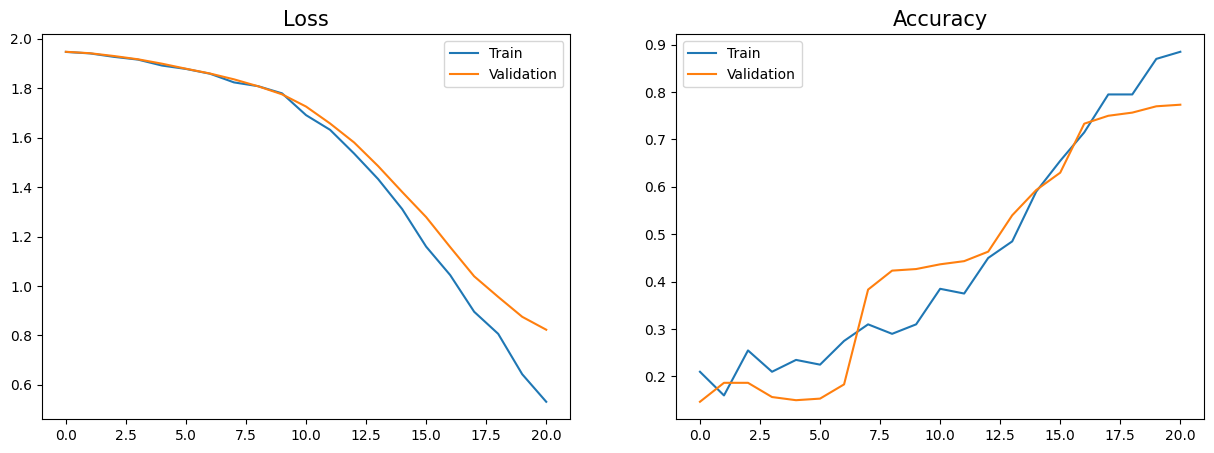

In [58]:

n_labels = labels.max().item() + 1  # 分类个数 7
# 每个论文节点的关键词属性个数，样本特征的维度
n_features = features.shape[1]  # 节点个数 1433
print(n_labels, n_features)
model = GCN(n_features, n_labels, hidden=[16, 32, 16]).to(device)
optimizer = Ranger(model.parameters())
# 训练模型
epochs = 1000  # 400#500
print_steps = 50
train_loss, train_acc = [], []
val_loss, val_acc = [], []
for i in tqdm(range(epochs)):
    tl, ta = train()
    train_loss += [tl]
    train_acc += [ta]
    if (i + 1) % print_steps == 0 or i == 0:
        tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss += [vl]
        val_acc += [va]
        print(f'{i + 1:6d}/{epochs}: train_loss={tl:.4f}, train_acc={ta:.4f}' +
              f', val_loss={vl:.4f}, val_acc={va:.4f}')

# 输出最终结果
final_train, final_val, final_test = evaluate(idx_train), evaluate(idx_val), evaluate(idx_test)
print(f'Train     : loss={final_train[0]:.4f}, accuracy={final_train[1]:.4f}')
print(f'Validation: loss={final_val[0]:.4f}, accuracy={final_val[1]:.4f}')
print(f'Test      : loss={final_test[0]:.4f}, accuracy={final_test[1]:.4f}')

# 可视化训练过程
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
axes[1].plot(train_acc[::print_steps] + [train_acc[-1]], label='Train')
axes[1].plot(val_acc, label='Validation')
for ax, t in zip(axes, ['Loss', 'Accuracy']): ax.legend(), ax.set_title(t, size=15)

# 输出模型预测结果
output = model(features, adj)

samples = 10
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v: k for k, v in lbl2idx.items()}
real_label = [idx2lbl[e] for e in labels[idx_sample].tolist()]
pred_label = [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]
df = pd.DataFrame({'Real': real_label,
                   'Pred': pred_label,
                   'Right': ['√' if real_label[i] == pred_label[i] else '×' for i in range(samples)]})
print(df)
